# Numerical Fourier Transforms

In [1]:
from __future__ import print_function
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this exercise we'll explore how one can take Fourier transforms numerically using Python. Recall that the Discrete Fourier Transform (DFT) of a discrete set of points $g_1 = g(t_1)$, $g_2 = g(t_2) $, ..., $g_N = g(t_N = T)$ is defined to be

$\tilde{g}_n \equiv \sum_{m=1}^N g_m \exp \left( \frac{-i 2 \pi m n }{N} \right)$

which tells us how much of each complex exponential is needed to reconstruct the series of $g_m$ values. This reconstruction is accomplished by the inverse Discrete Fourier transform, given by

$g_m \equiv \frac{1}{N} \sum_{n=1}^N \tilde{g}_n \exp \left( \frac{+i 2 \pi m n }{N} \right)$.

Python has built-in functions to compute Fourier transforms. They can be found under `np.fft`, where "FFT" stands for "Fast Fourier Transform". The FFT is mathematically the same as the DFT, but uses various internal computing tricks to make things "fast". Let's try it out!

## Tophat Example

The tophat function is a function is a function that is $1$ close to the origin but zero everywhere else.

In [2]:
def tophat(t,a):
    out = t.copy()
    for i,elem in enumerate(t):
        if abs(elem) > a:
            out[i] = 0.
        else:
            out[i] = 1.
    return out

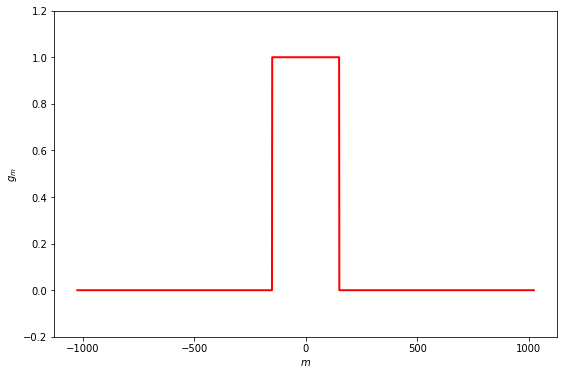

In [4]:
m_coords = np.arange(-1024, 1024)
gt = tophat(m_coords,150)

f, ax = plt.subplots(figsize=(9,6))
ax.plot(m_coords,gt,lw=2,c='red')
ax.set_xlabel(r"$m$")
ax.set_ylabel(r"$g_m$")
ax.set_ylim(-0.2, 1.2)
plt.show()

Here, you'll see that rather than having $m$ start at zero, I decided to have it be centered around zero, so that the $g_m$'s start from $m= -N/2$ rather than $m=0$. This is typical of a lot of our data. However, the slightly irritating thing about most numerical FFT routines is that they assume we're starting at $m=0$ Luckily, `numpy` provides a handy routine called "fftshift" that can be used to put our data into the right format.

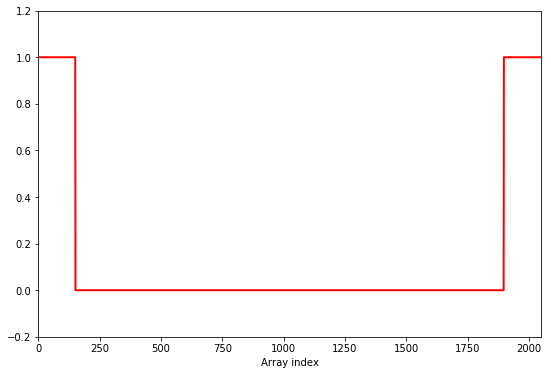

In [6]:
f, ax = plt.subplots(figsize=(9,6))
ax.plot(np.fft.fftshift(gt),lw=2,c='red')
ax.set_xlim(0,2048)
ax.set_ylim(-0.2,1.2)
ax.set_xlabel("Array index")
plt.show()

Indeed, the first element of the array now corresponds to $g_0$. But notice how the part of the function immediately to the left of $m=0$ is now on the far right! It turns out that FFTs assume that axes "wrap around". So in our new ordering scheme, the data goes from $m=0$ to $m=-N/2$, and then goes from $t=-N/2$ back up to $t=0$. Thus, the left half of the bump at appears on the far right. Said differently, FFTs assume that our function is periodic. In this way, FFTs are actually quite closely related to Fourier *Series* (which, remember, are for like Fourier transforms for periodic functions).

The FFT algorithm also orders the *output* of the FFT with $\tilde{g}_0$ as the first element. Thus, the output needs to be adjusted too, and the whole process is given by an initial np.fft.fftshift, the actual FFT using np.fft.fft, and the reordering of the final result using another np.fft.fftshift:

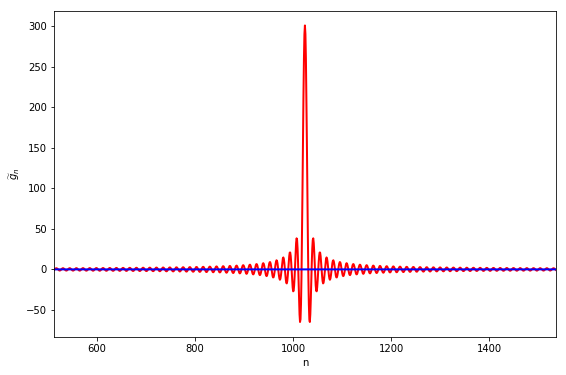

In [11]:
gtilde = np.fft.fftshift(np.fft.fft(np.fft.fftshift(gt)))

f, ax = plt.subplots(figsize=(9,6))
ax.plot(gtilde.real,lw=2,c='red')
ax.plot(gtilde.imag,lw=2,c='blue')
ax.set_xlim(512,1536)
ax.set_xlabel("n")
ax.set_ylabel(r"$\widetilde{g}_n$")
plt.show()

This is known as a <b> sinc </b> function.  What happens because of the symmetry of the original function? 

This looks like the function $\tilde{g} (f) = \sin (2 \pi f) / \pi f$ that we would've predicted by doing the analytic version of the Fourier transform. But whereas the pencil-and-paper version gave us a continuous function of $f$, here we have a bunch of values in an array, and we need to know which value of $f$ each element of the output array corresonds to. It turns out that numpy has a function called np.fft.fftfreq for this. As input, it needs to know the length of the original input array to the FFT, as well as the spacing in $f$ that is assumed there.

## The Fourier transform of a Gaussian

The Gaussian function is given by

$g(m) = \frac{1}{\sqrt{2 \pi a^2}}\exp \left[-\frac{(m-b)^2}{2 a^2}\right]$,

and is charaterized by two parameters, the location $b$ of its peak, and its width $a$ (rigorously, this width is defined as the standard deviation of the curve). Because of the way Gaussians look, they're often also known as Bell curves:

In [9]:
def gauss(t,a,b):
    exponent = -(t-b)**2
    exponent /= 2*a**2
    return np.exp(exponent)/np.sqrt(2.*np.pi*a**2)

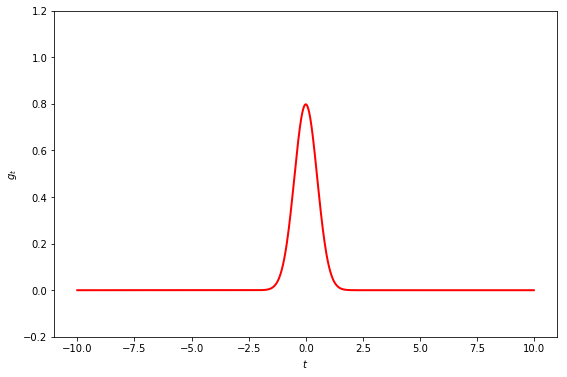

In [13]:
t_coords = np.linspace(-10.,10.,1025)[:-1]

f, ax = plt.subplots(figsize=(9,6))
ax.plot(t_coords,gauss(t_coords,0.5,0.),lw=2,c='red')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$g_t$")
ax.set_ylim(-0.2, 1.2)
plt.show()

<b> Q1. What is the Fourier transform of a Gaussian that is centered on the origin?

<b> Solution:

<b> Q2. Suppose we want to make $g(t)$ more squished together.  How would we change $a$?  What happens to its Fourier transform $\tilde{g}(f)$?

<b> Solution:

<b> Q2. Suppose we change the value of $b$ away from zero (to say 2).  What happens to $g(t)$? What happens to its Fourier transform $\tilde{g}(f)$?

<b> Solution: